In [1]:
using FFTW, LinearAlgebra
function cubiccos(c1,c2,c3) # Input: Cosine coefficients
    m = length(c1)
    a1 = [reverse(c1[2:end]); c1] # Fourier coefficient
    a2 = [reverse(c2[2:end]); c2] # Fourier coefficient
    a3 = [reverse(c3[2:end]); c3] # Fourier coefficient
    N = 2m # (p-1)m
    ta1 = [zeros(N,1);a1;zeros(N,1)] # 1. Padding zeros
    ta2 = [zeros(N,1);a2;zeros(N,1)]
    ta3 = [zeros(N,1);a3;zeros(N,1)]
    tb1 = ifft(ifftshift(ta1)) # 2. IFFT of ta
    tb2 = ifft(ifftshift(ta2))
    tb3 = ifft(ifftshift(ta3))
    tb³ = tb1 .* tb2 .* tb3    # 3. tb *^ tb *^ tb
    c³ = real(fftshift(fft(tb³))*(6m-1)^2) # 4. FFT of tb_cubic
    return c³[N+m:N+m+3*(m-1)] # return Cosine coefficients
end

function powerconvcos(c,p)
    m = length(c)
    a = [reverse(c[2:end]); c]# Fourier coefficient
    N = (p-1)*m
    ta = [zeros(N,1);a;zeros(N,1)] # 1. Padding zeros
    tb = ifft(ifftshift(ta)) # 2. IFFT of ta
    tbᵖ = tb.^p # 3. tb*^tb
    cᵖ = real(fftshift(fft(tbᵖ))*(2.0*p*m-1)^(p-1)) # 4. FFT of tb2
    return cᵖ[N+m:N+m+p*(m-1)]# return Chebyshev coefficients
end

powerconvcos (generic function with 1 method)

In [2]:
function F_equilibrium(c,λ) # Input: cosine Fourier
    N = length(c)-1 # maximum wave (N = m-1)
    k = (0:N)
    c3 = cubiccos(c,c,c)
    μ = λ .- (1 .- k.^2).^2
    return μ .* c - c3[1:N+1]
end

function DF_equilibrium(c,λ)
    N = length(c)-1 # maximum wave (N = m-1)
    k = (0:N)
    DF_linear = λ .- (1 .- k.^2).^2
    DF_nonlinear = zeros(N+1,N+1)
    c2 = powerconvcos(c,2)
    DF_nonlinear[:,1] = -3 * c2[k .+ 1]
    for j = 1:N
        DF_nonlinear[:,j+1] = -3 * (c2[abs.(k .- j) .+ 1] + c2[abs.(k .+ j) .+ 1])
    end
    return diagm(DF_linear) + DF_nonlinear
end

# function finite_diff_DF(c,λ)
# h=1e-8
# m=length(c)
# E=Matrix{Float64}(I,m,m)
# Df=zeros(m,m)
# for j=1:m
#     ch = c .+ h*E[:,j]
#     Df[:,j] = (F_equilibrium(ch,λ) -  F_equilibrium(c,λ))/h
# end
#     return Df
# end

DF_equilibrium (generic function with 1 method)

In [ ]:
# c = ones(10)
# @show F_equilibrium(c,1.0)
# DF = DF_equilibrium(c,1.0)
# DF_finite = finite_diff_DF(c,1.0)
# DF - DF_finite

In [3]:
using LinearAlgebra

function newton_F(c,λ)
    # Newton iteration
    num_itr = 0; p = 1; tol = 5e-10
    Fc = F_equilibrium(c,λ)
    println("Before iteration: $(norm(Fc,p))")
    while num_itr ≤ 100
        DF = DF_equilibrium(c,λ)
        c = c - DF\Fc
        num_itr += 1
        Fc = F_equilibrium(c,λ)
        println("After $(num_itr) iteration: $(norm(Fc,p))")
        if norm(Fc,p) < tol
            break
        end
    end
    return c
end

newton_F (generic function with 1 method)

In [24]:
m=10
u0 = 100*randn(m)./(1:m).^2
# c0 = 100*randn(10)./(1:10).^2
λ = 1.0
# λ = 150.0
u0 = newton_F(u0,λ)
# for λ = 1.0:0.1:2.5
#     c0 = newton_F(c0,λ)
# end
ū = u0

Before iteration: 2.953274552876383e6
After 1 iteration: 875882.3256164382
After 2 iteration: 259704.29218869936
After 3 iteration: 76818.15402831677
After 4 iteration: 22541.825490184005
After 5 iteration: 6508.163247262195
After 6 iteration: 1854.1237680155577
After 7 iteration: 535.7800661098923
After 8 iteration: 157.8245137461459
After 9 iteration: 45.65011813596107
After 10 iteration: 12.91113625251966
After 11 iteration: 3.623610991524483
After 12 iteration: 0.963776945495619
After 13 iteration: 83.53520721448864
After 14 iteration: 73.7313914073969
After 15 iteration: 22.388941022253157
After 16 iteration: 6.143704542653576
After 17 iteration: 1.539980237702299
After 18 iteration: 0.3287228372979032
After 19 iteration: 0.04093912818858143
After 20 iteration: 0.0010374194338875718
After 21 iteration: 7.064325237880329e-7
After 22 iteration: 3.216922215434428e-13


10-element Vector{Float64}:
 -5.643982491973764e-14
  0.5788283965786193
  9.644733396693685e-18
 -0.0029831765954278213
  2.5372682624541185e-19
  5.1697975437665285e-6
 -1.4200294263465876e-20
 -8.935461725768868e-9
  1.1498927529918216e-20
  1.3896587701826177e-11

In [ ]:
c̄
 # -3.174206918025166e-17
 #  0.578828396578559
 #  7.64926383709692e-18
 # -0.00298317659542738
 #  3.307686656721567e-19
 #  5.16979754376579e-6
 #  3.110736687494745e-20
 # -8.935461725764542e-9
 # -9.5954875244702e-21
 #  1.3896587715387632e-11

In [25]:
using Plots
function plot_cos(a)
    cₖ = [reverse(a[2:end]); a]
    N = Int((length(cₖ)+1)/2)# 2N-1
    n_pad = 200
    cₖ_pad = [zeros(n_pad);cₖ;zeros(n_pad)]
    N_pad = N + n_pad
    h_pad = 2.0π/(2N_pad-1)
    xⱼ_pad = h_pad*(0:(2N_pad-2))
    
    fᴺⱼ_pad = real((2N_pad-1)*ifft(ifftshift(cₖ_pad)))
    # plot(xⱼ_pad[N_pad:end], fᴺⱼ_pad[N_pad:end], legend=false, title = "Plot cosine Fourier series",
    plot(xⱼ_pad[1:N_pad-1], fᴺⱼ_pad[1:N_pad-1], legend=false, title = "Plot cosine Fourier series",
        line=2,
        xlabel = "\$x\$",
        ylabel = "\$u(x)\$",)
end

plot_cos (generic function with 1 method)

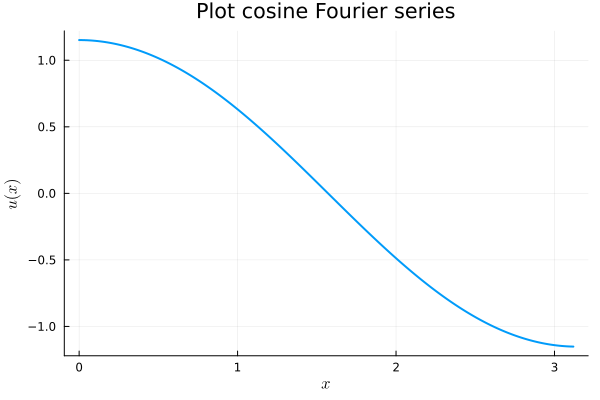

In [26]:
# c̄ = [0;0;.5;zeros(N-2)]
plot_cos(ū)
# savefig("steadystateSH.pdf")

In [8]:
# solve Swift-Hohenberg via RadiiPolynomal.jl
function F!(F, u, λ)
    ∂² = project(Derivative(2), space(u), space(u))
    project!(F, λ * u - (I + ∂²)^2 * u - u^3)
    return F
end

function DF!(DF, u, λ)
    ∂² = project(Derivative(2), space(u), space(u))
    add!(DF, λ * I - (I + ∂²)^2, Multiplication(-3u^2))
    return DF
end


DF! (generic function with 1 method)

In [17]:
using RadiiPolynomial
N = 20
λ = 6.0
# u = Sequence(CosFourier(N, 1.0), rand(N+1))
u = Sequence(CosFourier(N, 1.0/3.0), 100*randn(N+1)./(1:N+1).^2)
# 100*randn(N)./(1:N).^2

newton!((F, DF, u) -> (F!(F, u, λ), DF!(DF, u, λ)), u, maxiter = 100)

Newton's method: Inf-norm, tol = 1.0e-12, maxiter = 100
      iteration        |F(x)|
-------------------------------------
          0          3.7725e+04        |DF(x)\F(x)| = 7.0961e+00
          1          1.1168e+04        |DF(x)\F(x)| = 4.7128e+00
          2          3.3047e+03        |DF(x)\F(x)| = 3.0882e+00
          3          9.7660e+02        |DF(x)\F(x)| = 1.9723e+00
          4          2.8763e+02        |DF(x)\F(x)| = 1.1968e+00
          5          8.4058e+01        |DF(x)\F(x)| = 7.2296e-01
          6          2.4116e+01        |DF(x)\F(x)| = 5.1992e-01
          7          6.6229e+00        |DF(x)\F(x)| = 2.5343e-01
          8          1.4356e+00        |DF(x)\F(x)| = 1.6689e+00
          9          1.5091e+01        |DF(x)\F(x)| = 4.9325e-01
         10          3.4279e+00        |DF(x)\F(x)| = 2.1106e-01
         11          4.3421e-01        |DF(x)\F(x)| = 3.3996e-02
         12          1.6613e-02        |DF(x)\F(x)| = 4.6724e-03
         13          1.6219e-04

(Sequence(CosFourier(20, 0.3333333333333333), [-0.687353734922608, -0.6952342199738766, -0.7257106255679588, 0.9465045274646364, -0.18838302118827388, -0.09985770608956432, -0.02614245726755767, 0.014770811072458525, 0.0363805253537559, -0.02428949353213138  …  0.0013641353403558258, 0.0004540658321389898, -5.291028035476155e-5, -0.0004590796866954952, 0.0002227888818805184, -4.823578911389451e-7, -1.0115117512112824e-5, -6.329349305288472e-6, -1.5407691144719622e-6, 5.1716780339417145e-6]), true)

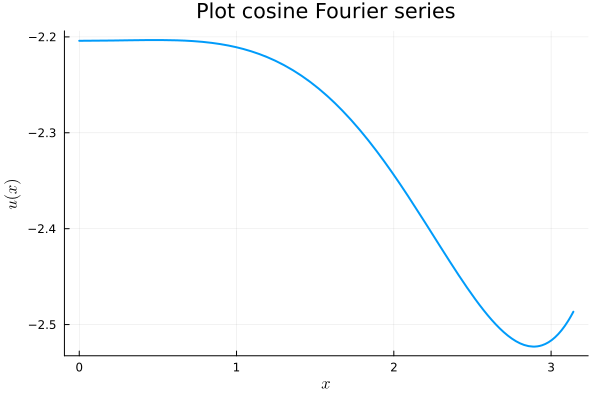

In [18]:
# u = Sequence(CosFourier(N, 1.0), [0;.5;zeros(N-1)])
plot(x -> u(x),0 ,π, legend=false, title = "Plot cosine Fourier series",
        line=2,
        xlabel = "\$x\$",
        ylabel = "\$u(x)\$",)
# savefig("steadystate2SH.pdf")

# $A^\dagger$, $A$の計算

In [27]:
DF_ū = DF_equilibrium(ū,λ) # DF^{(m)}(c̄^{(m)})
Am = inv(DF_ū)

10×10 Matrix{Float64}:
 -0.551788     -9.80694e-14   0.109834     …  -3.01066e-9    8.26525e-21
 -4.90347e-14  -0.502471      1.1007e-16       1.80416e-20  -1.06696e-10
  0.0549168     1.1007e-16   -0.110975         2.87232e-9    5.23972e-22
  9.15959e-16   0.00760904   -3.36386e-16     -2.4751e-22    1.64203e-10
 -0.000266976   3.92176e-18   0.000493503     -1.24391e-8   -1.22645e-24
 -2.63327e-18  -2.20857e-5    9.59308e-19  …   5.45194e-22  -2.91676e-9
  6.99984e-7    3.37087e-20  -1.34061e-6       2.04389e-7    1.6241e-22
  2.51987e-20   5.33732e-8   -2.76692e-21     -2.13793e-20   6.7423e-8
 -1.50533e-9    1.80416e-20   2.87232e-9      -0.000251889  -7.70535e-21
  4.13262e-21  -1.06696e-10   5.23972e-22     -7.70535e-21  -0.000156225

# $Y_0$評価

In [28]:
using LinearAlgebra

function wnorm(a,ν)
    m = length(a)
    nu_power = [1; 2*ν.^(1:m-1)]
    return sum(abs.(a).*nu_power)
end

function wnorm_mat(M,ν)
    m = size(M,2)
    nu_power = [1; 2*ν.^(1:m-1)]
    return maximum(sum(abs.(M) .* nu_power, dims=1)./nu_power')
end

wnorm_mat (generic function with 1 method)

In [29]:
ν = 1.0
m = length(ū)
function F_ext(c,λ) # Input: cosine Fourier
    N = length(c)-1 # maximum wave (N = m-1)
    c_ext = zeros(3N+1)
    c_ext[1:N+1] = c
    k = (0:3N)
    c3 = cubiccos(c,c,c)
    return λ*c_ext - (1 .- k.^2).^2 .* c_ext - c3
    # -k.^2*omega^2 .* a + a2[N+1:end]
end
f_ū = F_ext(ū,λ)
fm = f_ū[1:m]

k = m:3*(m-1)
μ = λ .-  (1 .- k.^2).^2

f_ū[1:m] .= 0
f_ū[m+1:end] = f_ū[m+1:end] ./ μ

Y0 = wnorm(Am*fm,ν) + wnorm(f_ū,ν)

2.181921906193553e-13

# $Z_0$評価

In [30]:
Z0 = wnorm_mat(I - Am * DF_ū,ν)

3.371959801136795e-16

# $Z_1$評価

In [31]:
Ψ = zeros(m)
c2_ext = zeros(6(m-1))
c2 = powerconvcos(ū,2)
c2_ext[1:2(m-1)+1] = c2


for k = 0:m-1
    tmp = 0
    for k1 = m:k+2(m-1)
        # @show c2_ext[abs(k-k1)+1] + c2_ext[abs(k+k1)+1]
        tmp = max(tmp, abs(c2_ext[abs(k-k1)+1] + c2_ext[abs(k+k1)+1])/(2ν^(k1)))
    end
    Ψ[k+1] = tmp
end
μₘ = λ .- (1 .- m^2)^2
Z1 = wnorm(3*Am*Ψ,ν) + 3*wnorm(c2,ν)/abs(μₘ)

0.0008291442378633967

# $Z_2$評価

In [32]:
function Mopnorm(M,ν,δ)
    return max(wnorm_mat(M,ν),δ)
end
A_opnorm = Mopnorm(Am,ν,1/abs(μₘ))
c1 = wnorm(ū,ν)

Z2(r) = 3*A_opnorm*(r+2*c1)

Z2 (generic function with 1 method)

# Radii-polynomial

In [33]:
p(r) = Z2(r)*r^2 - (1-Z0-Z1)*r + Y0

p (generic function with 1 method)

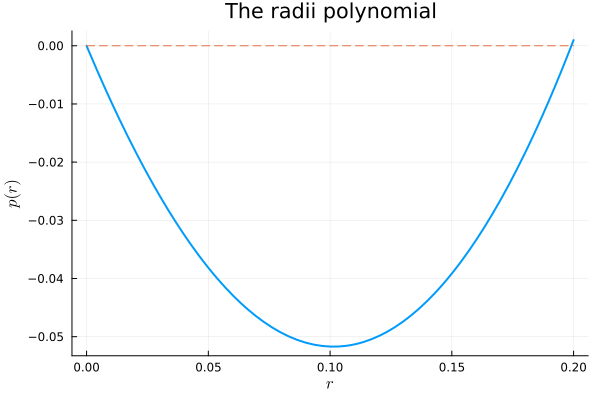

In [34]:
plot(p,0,0.2,
    line = 2,
    legend = false,
    title = "The radii polynomial",
    xlabel = "\$r\$",
    ylabel = "\$p(r)\$",
)
plot!(x->0,0,0.2,linestyle=:dash)

In [35]:
using ForwardDiff
#ニュートン法で近似解を計算する
function newton(F,x0)
    #初期値を設定
    tol = 1e-12; count = 0
    x = x0
    Fx = F(x)
    #条件の範囲内で計算を回す
    while maximum(abs.(Fx))/minimum(abs.(x)) ≥ tol && count ≤ 20
        DF = ForwardDiff.derivative(F,x)
        x -= DF\Fx
        Fx = F(x)
        count += 1
    end
    return x
end

newton (generic function with 1 method)

In [36]:
rmin = newton(p,Y0)

2.183732535444557e-13

In [37]:
rmax = newton(p,1)

0.19909556012374668